In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

In [39]:
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 10_000
EMBEDDING_DIM = 100
LATENT_DIM = 512

In [40]:
file_path = tf.keras.utils.get_file(
    'kor.txt',
    'https://github.com/ironmanciti/NLP_lecture/raw/master/data/kor.txt'
)
file_path

'/root/.keras/datasets/kor.txt'

In [41]:
eng_texts = []
kor_inputs = []
kor_targets = []

for line in open(file_path, 'r', encoding='utf-8'):
    if '\t' not in line:
        continue
    english, korean, attribution = line.split('\t')
    input = '<sos> ' + korean
    target = korean + ' <eos>'
    eng_texts.append(english)
    kor_inputs.append(input)
    kor_targets.append(target)

len(eng_texts), len(kor_inputs), len(kor_targets)

(3318, 3318, 3318)

In [42]:
print(eng_texts[1100: 1110])
print(kor_inputs[1100: 1110])
print(kor_targets[1100: 1110])

["Don't lie anymore, OK?", "Don't you laugh at me.", 'French is fascinating.', 'French is interesting.', 'French is very useful.', 'He looked quite tired.', 'He was about to speak.', 'He was born in Africa.', 'I called Tom for help.', "I didn't come by taxi."]
['<sos> 거짓말 하지 마세요, 알았죠?', '<sos> 날 비웃지마.', '<sos> 프랑스어는 매력적이야.', '<sos> 프랑스어는 흥미로워.', '<sos> 프랑스어는 아주 유용해.', '<sos> 그사람은 좀 지쳐보였어.', '<sos> 그사람이 말하려고 했어.', '<sos> 그는 아프리카에서 태어났다.', '<sos> 나는 톰에게 도움을 요청했다.', '<sos> 택시로 안 왔어.']
['거짓말 하지 마세요, 알았죠? <eos>', '날 비웃지마. <eos>', '프랑스어는 매력적이야. <eos>', '프랑스어는 흥미로워. <eos>', '프랑스어는 아주 유용해. <eos>', '그사람은 좀 지쳐보였어. <eos>', '그사람이 말하려고 했어. <eos>', '그는 아프리카에서 태어났다. <eos>', '나는 톰에게 도움을 요청했다. <eos>', '택시로 안 왔어. <eos>']


In [43]:
tokenizer_eng = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_eng.fit_on_texts(eng_texts)
eng_sequences = tokenizer_eng.texts_to_sequences(eng_texts)
max_len_eng = max(len(s) for s in eng_sequences)
num_words_eng = min(MAX_VOCAB_SIZE, len(tokenizer_eng.word_index) + 1)

eng_sequences[1500], eng_texts[1500], max_len_eng, num_words_eng

([126, 12, 6, 94, 153], 'Yesterday was a good day.', 101, 2396)

In [44]:
tokenizer_kor = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_kor.fit_on_texts(kor_inputs + kor_targets)
kor_input_sequences = tokenizer_kor.texts_to_sequences(kor_inputs)
kor_target_sequences = tokenizer_kor.texts_to_sequences(kor_targets)
max_len_kor = max(len(s) for s in kor_target_sequences)
num_words_kor = min(MAX_VOCAB_SIZE, len(tokenizer_kor.word_index) + 1)

kor_input_sequences[1500], kor_inputs[1500], kor_target_sequences[1500], kor_targets[1500], max_len_kor, num_words_kor

([1, 1164, 87, 2706],
 '<sos> 어제는 좋은 날이었다.',
 [1164, 87, 2706, 2],
 '어제는 좋은 날이었다. <eos>',
 90,
 5325)

In [45]:
encoder_inputs = pad_sequences(eng_sequences, maxlen=max_len_eng)

encoder_inputs.shape, encoder_inputs[1500]

((3318, 101),
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0, 126,  12,   6,  94, 153], dtype=int32))

In [46]:
decoder_inputs = pad_sequences(kor_input_sequences, maxlen=max_len_kor, padding='post')

decoder_inputs.shape, decoder_inputs[1500]

((3318, 90),
 array([   1, 1164,   87, 2706,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32))

In [47]:
decoder_targets = pad_sequences(kor_target_sequences, maxlen=max_len_kor, padding='post')

decoder_targets.shape, decoder_targets[1500]

((3318, 90),
 array([1164,   87, 2706,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32))

In [48]:
def make_embedding(num_words, embedding_dim, tokenizer, max_vocab_size):
    embeddings_dict = {}
    output = 'data/glove.6B.100d.txt'
    with open(output, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = coefs
    embedding_matrix = np.zeros((num_words, embedding_dim))
    print('num_words:', num_words)
    print(embedding_matrix.shape)

    for word, idx in tokenizer.word_index.items():
        if idx < max_vocab_size:
            embedding_vector = embeddings_dict.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
    return embedding_matrix

In [49]:
num_words = min(MAX_VOCAB_SIZE, len(tokenizer_kor.word_index) + 1)
num_words

5325

In [50]:
embedding_matrix = make_embedding(num_words_eng, EMBEDDING_DIM, tokenizer_eng, MAX_VOCAB_SIZE)
embedding_layer = Embedding(num_words_eng, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)

num_words: 2396
(2396, 100)


In [51]:
encoder_inputs_ = Input(shape=(max_len_eng,), name='Encoder_Input')
x = embedding_layer(encoder_inputs_)
_, h, c = LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = Model(encoder_inputs_, encoder_states)
encoder_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 101)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 101, 100)          239600    
                                                                 
 lstm_4 (LSTM)               [(None, 512),             1255424   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1495024 (5.70 MB)
Trainable params: 1495024 (5.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
decoder_inputs_ = Input(shape=(max_len_kor,), name='Decoder_Input')
decoder_embedding = Embedding(num_words_kor, EMBEDDING_DIM)
decoder_x = decoder_embedding(decoder_inputs_)
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_kor, activation='softmax', name='Decoder_Output')
decoder_outputs = decoder_dense(decoder_outputs)
model_teacher_forcing = Model([encoder_inputs_, decoder_inputs_], decoder_outputs)
model_teacher_forcing.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(0.001), metrics=['accuracy'])
model_teacher_forcing.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder_Input (InputLayer)  [(None, 101)]                0         []                            
                                                                                                  
 Decoder_Input (InputLayer)  [(None, 90)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 101, 100)             239600    ['Encoder_Input[0][0]']       
                                                                                                  
 embedding_4 (Embedding)     (None, 90, 100)              532500    ['Decoder_Input[0][0]']       
                                                                                            

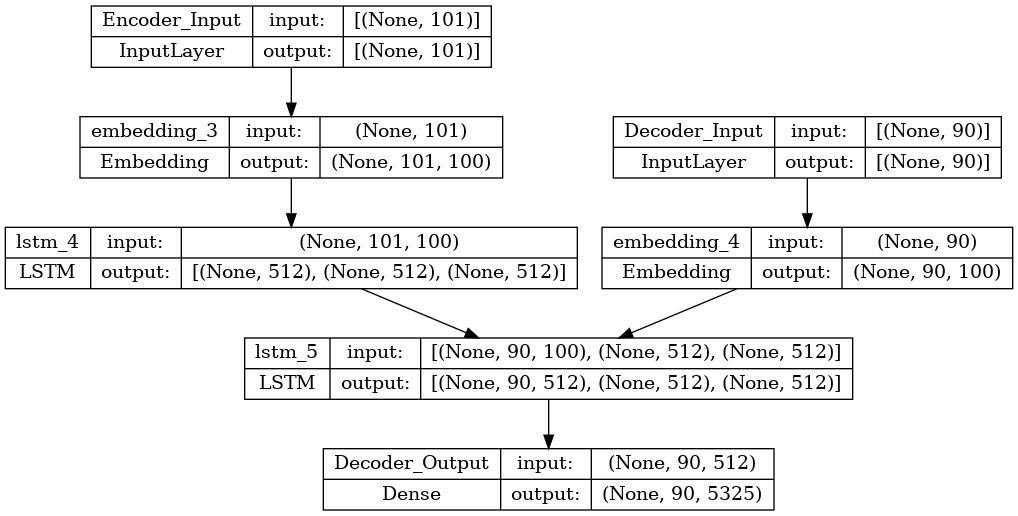

In [53]:
plot_model(model_teacher_forcing, show_shapes=True)

In [109]:
history = model_teacher_forcing.fit(
    [encoder_inputs, decoder_inputs], 
    decoder_targets, 
    batch_size=BATCH_SIZE,
    epochs=30,
    validation_split=0.2
)

Epoch 1/30
42/42 [==============================] - 3s 65ms/step - loss: 0.0520 - accuracy: 0.9925 - val_loss: 0.6804 - val_accuracy: 0.9322
Epoch 2/30
42/42 [==============================] - 2s 59ms/step - loss: 0.0512 - accuracy: 0.9927 - val_loss: 0.6802 - val_accuracy: 0.9324
Epoch 3/30
42/42 [==============================] - 2s 59ms/step - loss: 0.0507 - accuracy: 0.9928 - val_loss: 0.6803 - val_accuracy: 0.9317
Epoch 4/30
42/42 [==============================] - 3s 60ms/step - loss: 0.0495 - accuracy: 0.9930 - val_loss: 0.6834 - val_accuracy: 0.9318
Epoch 5/30
42/42 [==============================] - 3s 61ms/step - loss: 0.0492 - accuracy: 0.9931 - val_loss: 0.6833 - val_accuracy: 0.9319
Epoch 6/30
42/42 [==============================] - 3s 62ms/step - loss: 0.0488 - accuracy: 0.9933 - val_loss: 0.6830 - val_accuracy: 0.9320
Epoch 7/30
42/42 [==============================] - 3s 62ms/step - loss: 0.0474 - accuracy: 0.9935 - val_loss: 0.6853 - val_accuracy: 0.9319
Epoch 8/30
42

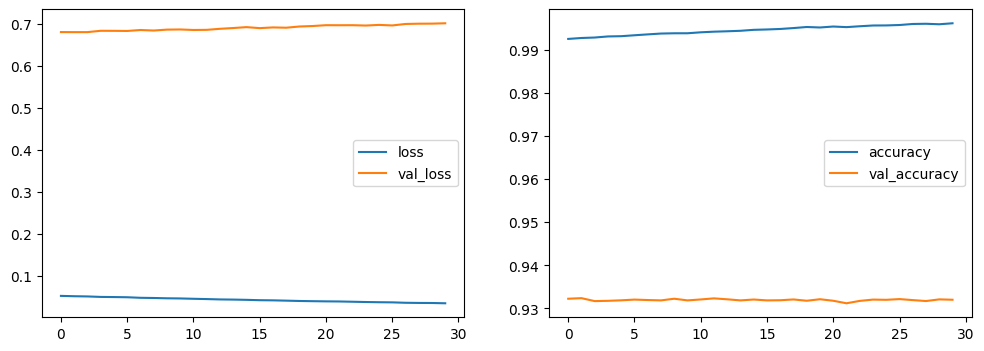

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend()
ax2.plot(history.history['accuracy'], label='accuracy')
ax2.plot(history.history['val_accuracy'], label='val_accuracy')
ax2.legend()
plt.show()

In [111]:
model_teacher_forcing.save('data/seq2seq_translation.h5')

/workspace/nlp/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [112]:
decoder_state_input_h = Input(shape=(512,), name='Decoder_hidden_h')
decoder_state_input_c = Input(shape=(512,), name='Decoder_hidden_c')
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_inputs_single = Input(shape=(1,), name='Decoder_input')
x = decoder_embedding(decoder_inputs_single)
decoder_outputs, h, c = decoder_lstm(x, initial_state=decoder_state_inputs)
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs_single] + decoder_state_inputs,
    [decoder_outputs] + decoder_states
)
decoder_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Decoder_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     multiple                     532500    ['Decoder_input[0][0]']       
                                                                                                  
 Decoder_hidden_h (InputLay  [(None, 512)]                0         []                            
 er)                                                                                              
                                                                                                  
 Decoder_hidden_c (InputLay  [(None, 512)]                0         []                     

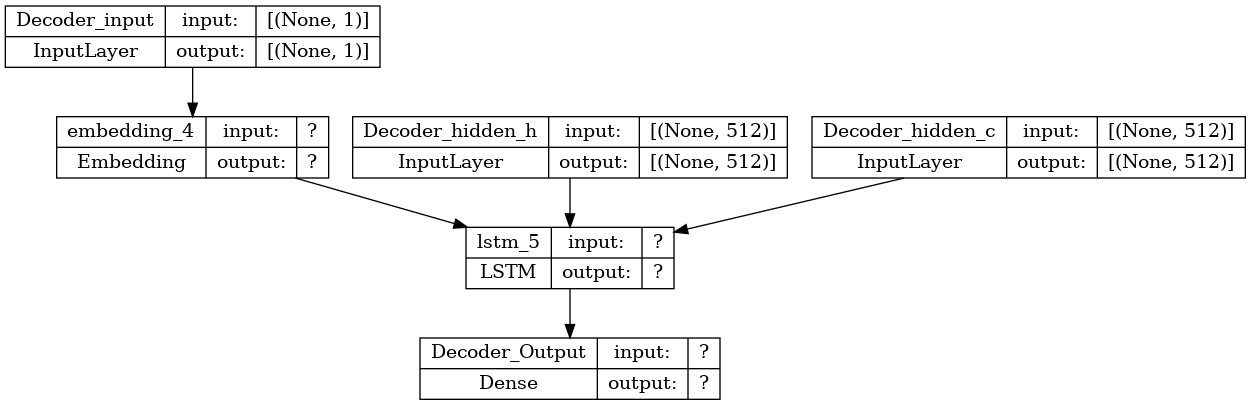

In [113]:
plot_model(decoder_model, show_shapes=True)

In [118]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_kor.word_index['<sos>']
    eos = tokenizer_kor.word_index['<eos>']

    output_sentence = []
    for _ in range(max_len_kor):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        idx = np.argmax(output_tokens[0, 0, :])
        if eos == idx:
            break
        if idx > 0: 
            word = tokenizer_kor.index_word[idx]
            output_sentence.append(word)
        target_seq[0, 0] = idx
        states_value = [h, c]
    return ' '.join(output_sentence)

In [119]:
for _ in range(5):
    i = np.random.choice(len(eng_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('input:', eng_texts[i])
    print('translation:', translation)

-
input: Could you loan me some money until payday?
translation: 집에 집에 집에 다시 가는지 돼?
-
input: Grab this.
translation: 이거 움켜쥐어.
-
input: She has a cat. The cat is white.
translation: 그 사람은 고양이를 키워. 그 고양이는 고양이야.
-
input: This is a lot more fun than studying.
translation: 아주 아주 아주 너무 읽겠어.
-
input: Do you believe this has any use?
translation: 이게 쓸모가 있을거라고 생각해?


In [120]:
def eng_kor_translation(txt):
    input_sequences = tokenizer_eng.texts_to_sequences([txt])
    encoder_input = pad_sequences(input_sequences, maxlen=max_len_eng)
    return decode_sequence(encoder_input)

In [121]:
test_text = [
       'Your lips are red.',
       'French is interesting.',
       'I like you.',
       "Let's go to home."      
]
for text in test_text:
      translation = eng_kor_translation(text)
      print('----')
      print('Input:', text)
      print('Translation:', translation)

----
Input: Your lips are red.
Translation: 네 입술 빨개.
----
Input: French is interesting.
Translation: 프랑스어는 흥미로워.
----
Input: I like you.
Translation: 네가 부러워.
----
Input: Let's go to home.
Translation: 저리 거기 거야.
